#### <left>Бронников Максим Андреевич</left>

*M8О-307Б, №4 по списку*

#   <center>Лабораторная работа №4</center>
### <center> Задание №2 </center>

**Реализовать метод стрельбы и конечно-разностный метод решения краевой задачи для ОДУ в виде программ. С использованием разработанного программного обеспечения решить краевую задачу для обыкновенного дифференциального уравнения 2-го порядка на указанном отрезке.**

**Оценить погрешность численного решения с использованием метода Рунге – Ромберга и путем сравнения с точным решением.**

### <center> Вариант №4 </center>

**Краевая задача:** 

$$
\begin{equation*}
 \begin{cases}
   x^2 (x+1)y''- 2y = 0
   \\
   y(1) = 1 + 4 \ln{2}
   \\
   y(2) = -1 + 3 \ln{2}
 \end{cases}
\end{equation*}
$$

Для $x \in [1, 2]$

**Точное решение:**

$$ y = -1 + \displaystyle\frac{2 + 2(x + 1)\ln{|x+1|}}{x} $$

<span style="color: red"> **Внимание:** Точное решение подобрано неверно, поэтому в уравнении будет заменено: $x^2 (x+1)y''- 2y + 2x - 2 = 0, \;$ $y(2) = 3 \ln{3}$</span>

<span style="color: red"> **Вывод сделан на основе проверки, сделанной в системе Maxima:** </span>

<img src="img/maxima.jpg" alt="Maxima" title="Maxima" />

## <center> Решение: </center>

### <center> Преобразование функции </center>

#### Для метода стрельбы

Сведём исходную задачу к системе 1-го порядка к краевым условием:

$$
\begin{equation*}
 \begin{cases}
   y' = z
   \\
   z' = \displaystyle\frac{2y + 2 - 2x}{x^2(x + 1)}
   \\
   y(1) = 1 + 4 \ln{2}
   \\
   z(1) = \eta
   \\
   y(2) = -1 + 3 \ln{2}
 \end{cases}
\end{equation*}
$$

Наша задача выбрать такое $\eta$, при котором значение решения на конце отрезка удовлетвоярет условию.

#### Для конечно-разностного метода

Выделим из дифференциального уравнения функции $p(x)$, $q(x)$ и $f(x)$, такие что: $y'' + p(x)y' + q(x)y = f(x)$:

$$
p(x) = 0,\; q(x) = -\displaystyle\frac{2}{x^2 (x+1)},\; f(x) = \displaystyle\frac{2 - 2x}{x^2 (x+1)}
$$

### <center> Вспомогательные функции </center>

Импортируем бибилиотеки:

In [1]:
import matplotlib.pyplot as plt
import math
import sys
import numpy as np
from functools import reduce

Функции $q(x), \; p(x), \; f(x)$:

In [2]:
def q_x(x):
    return -2 / (x*x*(x+1))

def p_x(x):
    return 0

def f_x(x):
    return (2 - 2*x) / (x*x*(x+1))

Функция $ y = -1 + \displaystyle\frac{2 + 2 (x+1) \ln{|x + 1|}}{x} $

In [3]:
def y_x(x):
    return -1 + (2 + 2*(x + 1)*math.log(abs(x + 1))) / x

Значение функции $f(x, y, z) = \displaystyle\frac{2 y - 2 x + 2}{x^2 (x+1)}$

In [4]:
def f_xyz(x, y, z):
    return (2*y - 2*x + 2) / (x*x*(x+1))

Функция, вычисляющая абсолютную погрешность $\| y - \overline{y} \|$ решения $y = y(x)$ задачи Коши приближением $\overline{y}$ в узловых точках:

In [5]:
def epsilon(x, y):
    norm = 0.0
    for i in range(len(x)):
        norm += (y[i] - y_x(x[i]))**2
    return norm**0.5

Функция вычисления вектора $x$ узловых точек на основе границ отрезка $a, \; b$ и длины шага $h$.

In [6]:
def compute_x(a, b, h):
    return list(np.arange(a, b + h/2, h))

Функция вычисляет многочлен Лагранжа $ L_n(x) = \displaystyle\sum\limits_{i = 0}^n f_n \displaystyle\prod\limits_{j = 0, j \ne n}^n \frac{(x - x_j)}{(x_n - x_j)} $:

In [7]:
# comute order of chislitels
# Multiply elems in order
def Prod(items = None):
    return reduce(lambda x, y: x*y, items)

# Compute order of znamenatels
def comp_order_znam(Xi):
    ans = []
    for item in Xi:
        ans.append(list(map(lambda it: item - it, filter(lambda it: it != item, Xi))))
    return map(lambda o: 1.0 / o, map(Prod, ans))

# Compute coeefs
def comp_coeffs(Xi, Yi):
    return [m*k for m, k in zip(Yi, comp_order_znam(Xi))]

def omega_order(x, Xi):
    ans = []
    for item in Xi:
        ans.append(list(map(lambda it: x - it, filter(lambda it: it != item, Xi))))
    return map(Prod, ans)

def lagrange_func(Xi, Yi):
    #compute coeefs
    coeffs = comp_coeffs(Xi, Yi)
    #return func
    return lambda x: sum([k*m for k, m in zip(coeffs, omega_order(x, Xi))])

Метод прогонкки решения трёхдиагональной системы уранений.

In [8]:
def race_method(A, b):
    P = [-item[2] for item in A]
    Q = [item for item in b]
    
    P[0] /= A[0][1]
    Q[0] /= A[0][1]
    
    for i in range(1, len(b)):
        z = (A[i][1] + A[i][0] * P[i-1])
        P[i] /= z
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= z
    
    x = [item for item in Q]
    
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    
    return x

Метод Рунге-Кутты 4-го порядка приближенного решения задачи Коши.

In [9]:
def delta_4p(xk, yk, zk, h, f):
    K1 = h * zk
    L1 = h * f(xk, yk, zk)
    
    K2 = h * (zk + L1 / 2)
    L2 = h * f(xk + h/2, yk + K1/2, zk + L1/2)
    
    K3 = h * (zk + L2 / 2)
    L3 = h * f(xk + h/2, yk + K2/2, zk + L2/2)
    
    K4 = h * (zk + L3)
    L4 = h * f(xk + h, yk + K3, zk + L3) 
    
    return ((K1 + 2*K2 + 2*K3 + K4)/6, (L1 + 2*L2 + 2*L3 + L4)/6)

def runge_kutta_4p(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    for k in range(len(x) - 1):
        delta = delta_4p(x[k], y[k], z[k], h, f)
        y.append(y[k] + delta[0])
        z.append(z[k] + delta[1])
    return y

### <center> Метод стрельбы </center>

Обозначим $\Phi(\eta) = y(b, y_0, \eta) - y(b)$, тогда иттерационная формула с конечным условием $\Phi(\eta_j) \leq \epsilon$, где $\epsilon$ - заданная точность метода:

$$
\eta_{j+2} = \eta_{j+1} - \Phi(\eta_{j+1}) \displaystyle\frac{\eta_{j+1} - \eta_j}{\Phi(\eta_{j+1}) - \Phi(\eta_j)}
$$

In [10]:
def next_step(F0, F1, nu0, nu1):
    return nu1 - F1 * (nu1 - nu0) / (F1 - F0)

Найдем $\eta$, такое что решение *задачи Коши* с шагом $h$ на правой границе отрезка $[a, b]$ соответствует краевому условию $y(b)$, где решение *задачи Коши* будем искать приближенно *методом Рунге-Кутты 4 порядка*. Поиск параметра $\eta$ будем производить иттерационно.

In [11]:
def shoot_method(x, y0, y1, h, f = f_xyz, e = 0.00001):
    nu_last = 1
    nu_now = 0.8
    y_last = runge_kutta_4p(x, y0, nu_last, h, f)
    y_now = runge_kutta_4p(x, y0, nu_now, h, f)
    F_last = y_last[-1] - y1
    F_now = y_now[-1] - y1
    while abs(F_now) > e:
        nu_last, nu_now = nu_now, next_step(F_last, F_now, nu_last, nu_now)
        y_last, y_now = y_now, runge_kutta_4p(x, y0, nu_now, h, f)
        F_last, F_now = F_now, y_now[-1] - y1
    return y_now

### <center> Конечно-разностный метод </center>

#### Краевые условия 1-го рода

Система для решения конечно-разностного уравнения с краевыми условиями 1-го рода для значений $y_i: \; 0 < i < N$ в узлах $x_i$, где $N$ - количество узлов:

$$
\begin{equation*}
 \begin{cases}
   (-2 + h^2 q(x_1)) y_1 + \left(1 + \displaystyle\frac{p(x_1) h}{2} \right)y_2 = h^2 f(x_1) - y_0\left(1 - \displaystyle\frac{p(x_1)h}{2}\right)
\\
   ...
\\
   y_{k-1} \left(1 - \displaystyle\frac{p(x_k)h}{2} \right) + (-2 + h^2 q(x_k)) y_k + \left(1 + \displaystyle\frac{p(x_k) h}{2} \right)y_{k+1} = h^2 f(x_k)
   \\
   ...
   \\
   y_{N-2} \left(1 - \displaystyle\frac{p(x_{N-1})h}{2} \right) + (-2 + h^2 q(x_{N-1})) y_{N-1} = h^2 f(x_{N-1}) - y_N \left(1 + \displaystyle\frac{p(x_{N-1})h}{2}\right)
 \end{cases}
\end{equation*}
$$

Здесь $f_i = f(x_i, y_i, z_i)$

Значения $y_0 = y(1)$ и $y_N = y(N)$ заданы в условии.

In [12]:
def compute_A(h, p, q, x):
    A = [[1 - (p(x[i]))/2, (-2 + h*h*q(x[i])), 1 + (p(x[i])*h)/2] for i in range(1, len(x[:-1]))]
    A[0][0] = 0
    A[-1][-1] = 0
    return A

def compute_b(h, p, f, x, y0, y1):
    b = [h*h*f(x[i]) for i in range(1, len(x[:-1]))]
    b[0] -= y0*(1 - p(x[1])*h/2)
    b[-1] -= y1*(1 + p(x[-2])*h/2)
    return b

In [13]:
def difference_method(x, y0, y1, h, p = p_x, q = q_x, f = f_x):
    A = compute_A(h, p, q, x)
    b = compute_b(h, p, f, x, y0, y1)
    y = [y0] + race_method(A, b) + [y1]
    return y

### <center> Метод Рунге-Ромберга-Ричардсона </center>

В случае приближённого решения $y_1$ и $y_2$ с постоянными шагами $h_1$ и $h_2$ соответственно и порядком точности $p$, где $h_2 = 2h_1 $ формула приближенного вычисления погрешности вычисления порядка точности $p + 1 \;$ $ R^h = \displaystyle\frac{\| y_1 - y_2 \|}{2^p - 1} \; $ реализуется:

In [14]:
def runge_romberg_rich_method(y1, y2, p):
    norm = 0.0
    for i in range(len(y2)):
        norm += (y1[i*2] - y2[i])**2
    return (norm**0.5) / (2**p - 1)

### <center> Демонстрация работы </center>

Начальные значения задаем в коде:

In [15]:
h = 0.2
a = 1
b = 2
y0 = 1 + 4 * math.log(2)
y1 = 3 * math.log(3)

Значения узловых точек, в которых будут приближаться решения задачи Коши:

In [16]:
x = compute_x(a, b, h)
xr = compute_x(a, b, h/2)

Абсолютная погрешность *метода стрельбы* с точностью $\epsilon = 0.00001$:

In [17]:
y = shoot_method(x, y0, y1, h)
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y: 5.7202524815136525e-05


Погрешность *метода стрельбы* с точностью $\epsilon = 0.00001$ с помощью *метода Рунге-Ромберга-Ричардсона*:

In [18]:
p = 4
yr = shoot_method(xr, y0, y1, h/2)
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y: 3.560776535488534e-06


Абсолютная погрешность *конечно-разностного метода* с условиями первого рода:

In [19]:
y = difference_method(x, y0, y1, h)
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y: 0.005618555966076985


Погрешность *конечно-разностного метода* с условиями первого рода с помощью *метода Рунге-Ромберга-Ричардсона:*

In [20]:
p = 2
yr = difference_method(xr, y0, y1, h/2)
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y: 0.001391897644023291


### <center> Графическое отображение </center>

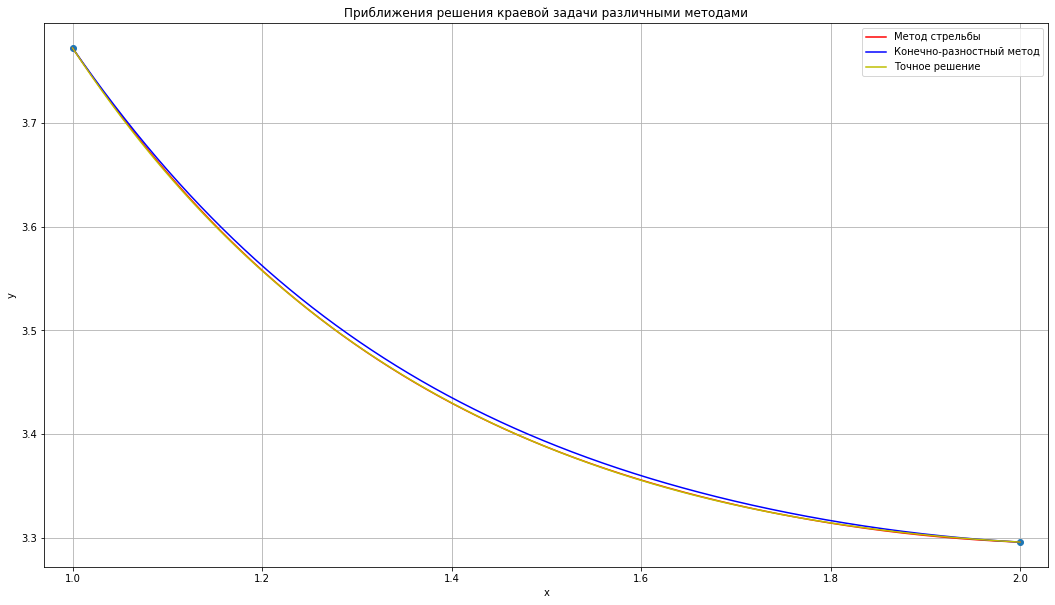

In [22]:
h = 0.25
a = 1
b = 2
y0 = 1 + 4 * math.log(2)
y1 = 3 * math.log(3)

xp = compute_x(a, b, h)
xi = compute_x(a, b, 0.0005)

yp1 = shoot_method(xp, y0, y1, h)
Ly = lagrange_func(xp, yp1)
ys = list(map(Ly, xi))

yp2 = difference_method(xp, y0, y1, h)
Ly = lagrange_func(xp, yp2)
yd = list(map(Ly, xi))

yt = list(map(y_x, xi))




fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

ax1.plot([a, b], [y0, y1], 'o')

line1, = ax1.plot(xi, ys, 'r')
line2, = ax1.plot(xi, yd, 'b')
line3, = ax1.plot(xi, yt, 'y')





ax1.set_xlabel('x')
ax1.set_ylabel('y')


# set title, plot limits, etc
ax1.set_title('Приближения решения краевой задачи различными методами')
ax1.set_xlim(0.97, 2.03)



ax1.legend((line1, line2, line3), 
           ("Метод стрельбы", "Конечно-разностный метод", "Точное решение"))
ax1.grid()


plt.show()

###### <center>Сделано Бронниковым Максимом</center>
###### <center>20.04.2020</center>